In [2]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

In [3]:
from pyha_analyzer import PyhaTrainer, PyhaTrainingArguments, extractors

In [4]:
coralreef_extractor = extractors.CoralReef()
coral_ads = coralreef_extractor("/home/s.kamboj.400/unzipped-coral")
coral_ads

Casting the dataset:   0%|          | 0/703 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/90 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/212 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['sample_rate', 'labels', 'filepath', 'audio', 'audio_in'],
        num_rows: 703
    })
    valid: Dataset({
        features: ['sample_rate', 'labels', 'filepath', 'audio', 'audio_in'],
        num_rows: 90
    })
    test: Dataset({
        features: ['sample_rate', 'labels', 'filepath', 'audio', 'audio_in'],
        num_rows: 212
    })
})

In [5]:
coral_ads["train"].features["labels"]

Sequence(feature=ClassLabel(names=['Degraded_Reef', 'Non_Degraded_Reef'], id=None), length=-1, id=None)

In [6]:
coral_ads["train"][0]

{'sample_rate': 48000,
 'labels': [0, 1],
 'filepath': '/home/s.kamboj.400/unzipped-coral/Non_Degraded_Reef/May_2025/20250314_075700.WAV',
 'audio': {'path': '/home/s.kamboj.400/unzipped-coral/Non_Degraded_Reef/May_2025/20250314_075700.WAV',
  'array': array([ 0.12234497, -0.21954346,  0.01226807, ..., -0.05276489,
          0.10263062, -0.06829834], shape=(2640000,)),
  'sampling_rate': 48000},
 'audio_in': {'array': '/home/s.kamboj.400/unzipped-coral/Non_Degraded_Reef/May_2025/20250314_075700.WAV',
  'sampling_rate': 48000}}

In [7]:
from pyha_analyzer.preprocessors import MelSpectrogramPreprocessors

# TODO: allow for normalization system

# preprocessor acts as a function for processing
# class allows us to configure parameters and whatnot
preprocessor = MelSpectrogramPreprocessors(duration=5, class_list=coral_ads["train"].features["labels"].feature.names)

coral_ads["train"].set_transform(preprocessor)
coral_ads["valid"].set_transform(preprocessor)
coral_ads["test"].set_transform(preprocessor)
coral_ads["train"][[0, 1]]["audio"][0].mean()

np.float32(0.2918156)

In [8]:
coral_ads["test"][0]

{'sample_rate': 48000,
 'labels': array([0., 1.], dtype=float32),
 'filepath': '/home/s.kamboj.400/unzipped-coral/Non_Degraded_Reef/May_2025/20250314_074300.WAV',
 'audio': array([[[0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.00392157],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.00392157, 0.00784314],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.00784314, 0.01176471],
         ...,
         [0.03921569, 0.08235294, 0.10588235, ..., 0.2901961 ,
          0.25490198, 0.12156863],
         [0.00392157, 0.00392157, 0.00392157, ..., 0.01176471,
          0.01176471, 0.00392157],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ]]], shape=(1, 256, 431), dtype=float32),
 'audio_in': array([[[0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.00392157],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.00

In [9]:
from pyha_analyzer.models import EfficentNet
#model = EfficentNet(num_classes=len(coral_ads["train"].features["ebird_code"].names))
model = EfficentNet(num_classes=2)

In [10]:
from pyha_analyzer import constants
args = PyhaTrainingArguments(
    working_dir="working_dir",
    run_name= constants.DEFAULT_RUN_NAME,
    project_name=constants.DEFAULT_PROJECT_NAME
)
args.num_train_epochs = 1
args.eval_steps = 20


trainer = PyhaTrainer(
    model=model,
    dataset=coral_ads,
    training_args=args,
)
trainer.train()

wandb: Currently logged in as: sskamboj (acoustic-species-identification) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


MultilabelAveragePrecision init with num_labels  2  and average  none


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Step,Training Loss,Validation Loss


TrainOutput(global_step=11, training_loss=0.6042839993130077, metrics={'train_runtime': 53.5807, 'train_samples_per_second': 13.12, 'train_steps_per_second': 0.205, 'total_flos': 0.0, 'train_loss': 0.6042839993130077, 'epoch': 1.0})

In [11]:
# Uncomment the following lines to save the git commit hash and model state_dict as pt file
# import subprocess
# import torch

# git_hash = subprocess.check_output(["git", "rev-parse", "HEAD"]).decode().strip()

# with open("training_info.txt", "w") as f:
#     f.write(f"Git commit: {git_hash}\n")

# #save model in .pt file associated with git hash. This is useful for reproducibility, so that we can always refer back to the exact code used for training.
# model_save_path = f"coral_model_{git_hash[:7]}.pt"
# torch.save(trainer.model.state_dict(), model_save_path)

In [12]:
trainer.evaluate(eval_dataset=coral_ads["test"], metric_key_prefix="Soundscape")

{'Soundscape_loss': 0.6666678786277771,
 'Soundscape_cMAP': 0.5447096824645996,
 'Soundscape_ROCAUC': 0.5519653558731079,
 'Soundscape_runtime': 14.2717,
 'Soundscape_samples_per_second': 14.855,
 'Soundscape_steps_per_second': 0.49,
 'epoch': 1.0}

In [24]:
from pyha_analyzer.metrics.gradcam import GradCAM
import torch
from pyha_analyzer.models import EfficentNet
from pyha_analyzer import constants, PyhaTrainer, PyhaTrainingArguments
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np

# Rebuild and load model, need to do this rather than train on fake model; otherwise, outputs are wrong
newModel = EfficentNet(num_classes=2)
newModel.load_state_dict(torch.load("coral_model_4146a1f.pt"))
newModel.eval()

# Rebuild trainer
args = PyhaTrainingArguments(
    working_dir="working_dir",
    run_name=constants.DEFAULT_RUN_NAME,
    project_name=constants.DEFAULT_PROJECT_NAME
)
args.num_train_epochs = 1
args.eval_steps = 20

trainer = PyhaTrainer(
    model=newModel,
    dataset=coral_ads,
    training_args=args,
)


target_layer = newModel.model.efficientnet.encoder.top_conv
print(target_layer)
gradcam = GradCAM(newModel.model, target_layer) # lets you use huggingface model code not the Pyha wrapper because you want to use that forward command


pdfPathDegraded = "Degraded_gradCAM.pdf"
pdfPathNonDegraded = "Non_Degraded_gradCAM.pdf" 
pDegraded = PdfPages(pdfPathDegraded) 
pNonDegraded = PdfPages(pdfPathNonDegraded)
countDegraded=0
countNonDegraded=0
numGradCams=199 # make it 99 to get 100 degraded & 100 non degraded
all_cam_pixels_degraded = []
all_cam_pixels_nondegraded = []

#cannot batch for grad cam
for i, item in enumerate(coral_ads["train"]):
    input_tensor = torch.tensor(item["audio_in"], dtype=torch.float32).unsqueeze(0)
    cam_output = gradcam.generate(input_tensor)
    cam_flat = cam_output.flatten()

    # generate (numGradCam +1) quantity of grad cams and save it in the pdf
    if ((countDegraded <=numGradCams) and (item["labels"] == [1,0]).all()):
        all_cam_pixels_degraded.extend(cam_flat)
        gradcam.show_gradcam_overlay(item, cam_output, pDegraded)
        countDegraded+=1
    elif ((countNonDegraded <=numGradCams) and (item["labels"] ==[ 0, 1]).all()):
        all_cam_pixels_nondegraded.extend(cam_flat)
        gradcam.show_gradcam_overlay(item, cam_output, pNonDegraded)
        countNonDegraded+=1
    if ((countNonDegraded > numGradCams) & (countDegraded > numGradCams)):
        break

pDegraded.close()
pNonDegraded.close()

#convert so that you can make histogram
degraded_vals = np.array(all_cam_pixels_degraded)
nondegraded_vals = np.array(all_cam_pixels_nondegraded)



MultilabelAveragePrecision init with num_labels  2  and average  none
Conv2d(320, 1280, kernel_size=(1, 1), stride=(1, 1), padding=same, bias=False)


/home/s.kamboj.400/pyha-analyzer-2.0/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py:1842: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


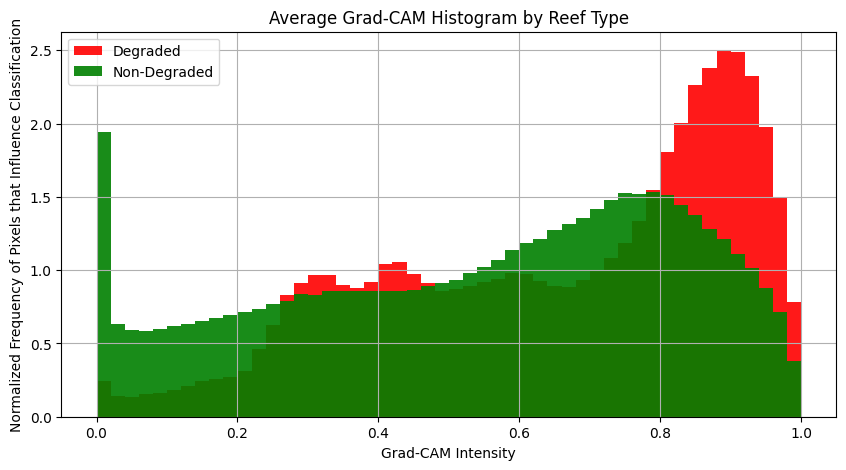

In [25]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.hist(degraded_vals, bins=50, range=(0, 1), alpha=0.9, label="Degraded", color="red", density=True)
plt.hist(nondegraded_vals, bins=50, range=(0, 1), alpha=0.9, label="Non-Degraded", color="green", density=True)
plt.xlabel("Grad-CAM Intensity")
plt.ylabel("Normalized Frequency of Pixels that Influence Classification")
plt.title("Average Grad-CAM Histogram by Reef Type")
plt.legend()
plt.grid(True)
plt.show()

In [19]:
#print(model.model) #make sure u get the lasst conv layer! check this to make sure

In [21]:
import lancedb
#Connect to LanceDB and save the embeddings
uri = "database/coral_reef_db.lance"
db = lancedb.connect(uri)

In [22]:
#delete the table for testing purposes, so that the same embeddings are not re-inserted because id is simply a key not a primary key, so embeddings can get reinserted
if "coral_embeddings" in db.table_names():
    #print("Table exists. If you run the next couple code blocks again, then you will get duplicate embeddings.")
    db.drop_table("coral_embeddings")

In [23]:
import pyarrow as pa
schema = pa.schema([
    pa.field("id", pa.string()),
    pa.field("vector_embedding", pa.list_(pa.float32(), list_size=1280)),
    pa.field("label", pa.string()),
    pa.field("audio_path", pa.string())
])
table = db.create_table("coral_embeddings", schema=schema)

In [16]:
import torch
batch_size = 32
table_rows=[]

for split in ["train", "valid"]:
    dataset = coral_ads[split]
    for i in range(0, len(dataset), batch_size):
        batch_items = dataset.select(range(i, min(i + batch_size, len(dataset))))

        # build input tensor
        batch_inputs = torch.stack([
            torch.tensor(item["audio_in"], dtype=torch.float32)
            for item in batch_items
        ])

        # get embeddings through batching
        embeddings = model.get_embedding(batch_inputs)

        # Loop through items and create metadata
        for j, (embedding, item) in enumerate(zip(embeddings, batch_items)):
            label_vec = item["labels"]
            if (label_vec == [0.0, 1.0]).all():
                curr_label = "Non_Degraded_Reef"
            elif (label_vec == [1.0, 0.0]).all():
                curr_label = "Degraded_Reef"
            else:
                curr_label = "Unknown"
                print("Unknown label:", label_vec)

            metadata = {
                "id": f"{split}{i + j}",
                "vector_embedding": embedding.tolist(),
                "label": curr_label,
                "audio_path": item["filepath"]
            }

            table_rows.append(metadata)

# Step 4: Insert all at once
table.add(table_rows)


AddResult(version=2)

In [17]:
# curr_split = "test"
# dataset = coral_ads[curr_split]
# batch_size = 16  

# for i in range(0, len(dataset), batch_size):
#     # Select a batch of size 16
#     batch_items = dataset.select(range(i, min(i + batch_size, len(dataset))))

#     # Create batched input tensor
#     batch_inputs = torch.stack([
#         torch.tensor(item["audio_in"], dtype=torch.float32)
#         for item in batch_items
#     ])  

#     # 3. Get embeddings for the batch of 16
#     embeddings = model.get_embedding(batch_inputs) 

#     # 4. Search LanceDB for each embedding
#     for item, embedding in zip(batch_items, embeddings):
#         query_vector = embedding.tolist()
#         results = table.search(query_vector).limit(1).to_pandas()

#         print("The most similar to", item["filepath"], "is", results["audio_path"].tolist()[0])
